<a href="https://colab.research.google.com/github/IgnacioRiffop/Convolutional-Neural-Networks/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
# Mostrar imágenes con OpenCV en Google Colab
from google.colab.patches import cv2_imshow
import cv2
import os
import glob
import collections
import itertools

# Manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow y Keras integrados
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

# Métricas y herramientas de evaluación
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from google.colab import files

# Subir archivos desde tu equipo local
uploaded = files.upload()

# Crear carpetas donde se descomprimirá el contenido
!mkdir -p /content/simpsons_train
!mkdir -p /content/simpsons_test

# Extraer los archivos .tar.gz
!tar -xzf /content/simpsons_train.tar.gz -C /content/simpsons_train
!tar -xzf /content/simpsons_test.tar.gz -C /content/simpsons_test


Saving simpsons_train.tar.gz to simpsons_train.tar.gz
Saving simpsons_test.tar.gz to simpsons_test.tar.gz


In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
import os

print("Train dir content:", os.listdir("/content/simpsons_train"))
print("Train subdir content:", os.listdir("/content/simpsons_train/simpsons")[:5])  # muestra 5 carpetas

print("Test dir content:", os.listdir("/content/simpsons_test"))
print("Test subdir content:", os.listdir("/content/simpsons_test/simpsons_testset")[:5])  # muestra 5 archivos

Train dir content: ['simpsons']
Train subdir content: ['abraham_grampa_simpson', 'hans_moleman', 'ralph_wiggum', 'martin_prince', 'edna_krabappel']
Test dir content: ['simpsons_testset']
Test subdir content: ['chief_wiggum_29.jpg', 'comic_book_guy_6.jpg', 'krusty_the_clown_2.jpg', 'principal_skinner_48.jpg', 'bart_simpson_35.jpg']


In [ ]:
# Ruta correcta al subdirectorio donde están las carpetas de personajes
DATASET_TRAIN_PATH_COLAB = "/content/simpsons_train/simpsons"

# Ruta correcta al subdirectorio donde están las imágenes de test
DATASET_TEST_PATH_COLAB = "/content/simpsons_test/simpsons_testset"

# Cargar datos
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


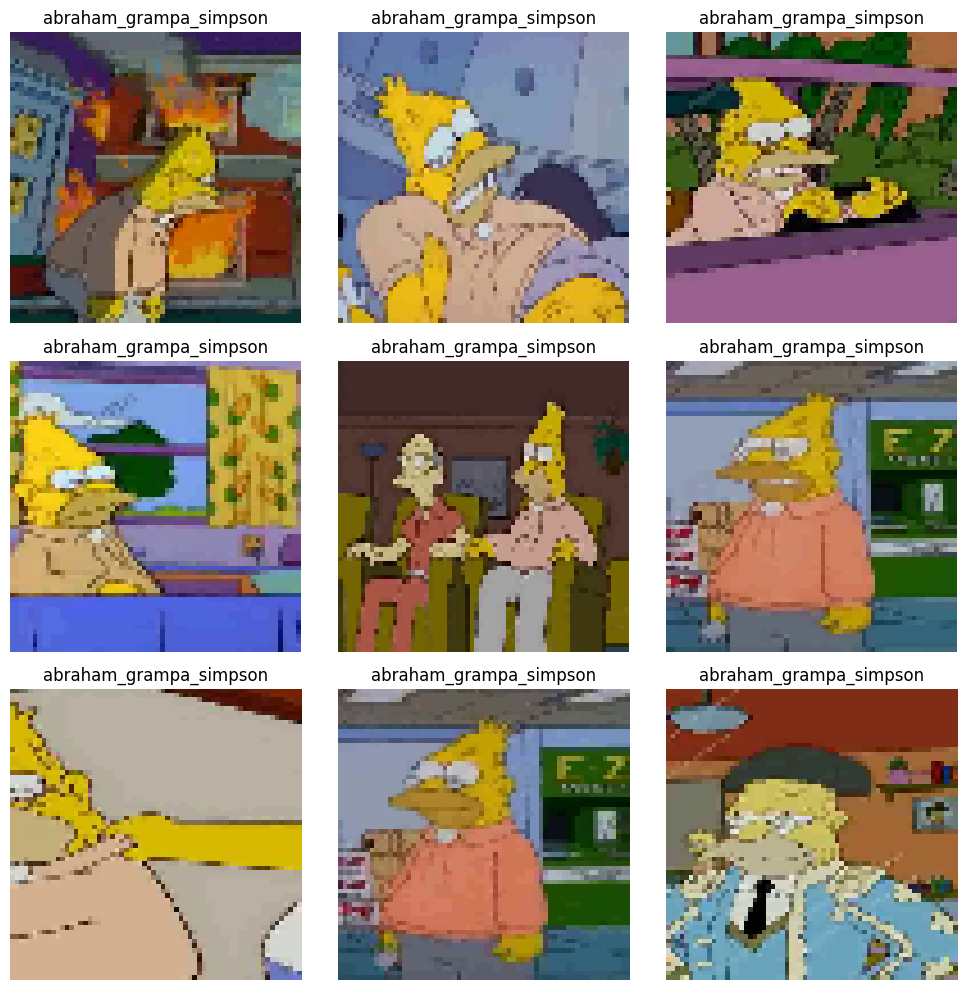

In [ ]:
# Mostrar algunas imágenes de entrenamiento
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    plt.title(MAP_CHARACTERS[y[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [ ]:
# Normalizar los valores de píxeles
X = X / 255.0
X_t = X_t / 255.0

# Codificación one-hot para las etiquetas
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=len(MAP_CHARACTERS))
y_t_cat = to_categorical(y_t, num_classes=len(MAP_CHARACTERS))

## Modelo CNN Simple: Arquitectura, Justificación y Optimización

### Diseño de la arquitectura CNN

- **Profundidad y número de filtros:**  
  El modelo cuenta con 2 bloques Conv2D con 32 y 64 filtros respectivamente. Elegí esta profundidad y número de filtros porque es suficiente para capturar características básicas sin hacer el modelo demasiado complejo ni propenso a sobreajuste, considerando el tamaño y la variedad del dataset.  
  Los filtros son de tamaño 3x3, que es un estándar en visión computacional, ya que captura patrones locales pequeños y se puede apilar para aprender patrones más complejos.

- **Uso de Batch Normalization y Dropout:**  
  Aunque en el modelo simple no incluimos BatchNorm (se reserva para modelos más profundos), usamos Dropout con tasa 0.25 para evitar sobreajuste. Dropout apaga aleatoriamente neuronas durante el entrenamiento, lo que obliga al modelo a no depender de una ruta única, mejorando la generalización.

### Selección de hiperparámetros

- **Learning rate:**  
  Usamos Adam con learning rate 0.001, un valor estándar que equilibra la rapidez de convergencia sin saltarse mínimos locales. Adam adapta la tasa de aprendizaje durante el entrenamiento, lo que mejora estabilidad y eficiencia.  

- **Batch size:**  
  Se eligió 64 para un buen balance entre estabilidad de gradiente y eficiencia computacional, además de permitir un entrenamiento relativamente rápido.  

- **Número de epochs:**  
  Entrenamos por 10 epochs, suficiente para observar convergencia inicial y evaluar si el modelo comienza a sobreajustar o no.

### Optimización y ajuste de hiperparámetros

- Se probó el uso de Dropout para mejorar la generalización y reducir overfitting, comparando resultados con y sin esta capa.  
- Aunque no se usó regularización L2 en este modelo simple, se implementó en el modelo más profundo para controlar la magnitud de los pesos.  
- Se observó que ajustar la tasa de aprendizaje y la profundidad de la red impacta directamente en la precisión y la estabilidad del entrenamiento, por lo que estos hiperparámetros deben ser ajustados con cuidado según el dataset y los recursos.

### Interpretación de resultados y métricas

El modelo simple logra extraer características básicas y obtener una precisión aceptable, pero muestra limitaciones en diferenciar personajes con rasgos similares, lo que indica la necesidad de arquitecturas más profundas o técnicas adicionales para mejorar el desempeño.

En el conjunto de test, el modelo obtuvo las siguientes métricas clave:  

- **Loss (pérdida):** 0.6985  
- **Accuracy (precisión):** 0.8101 (81.01%)  

Además, el reporte de clasificación muestra un buen desempeño general con precisión, recall y F1-score variables según la clase. Por ejemplo, personajes como *apu_nahasapeemapetilon* y *sideshow_bob* tienen métricas superiores al 90%, mientras que personajes con rasgos similares como *edna_krabappel* y *ned_flanders*, o *lisa_simpson* y *bart_simpson*, presentan más confusiones.

La matriz de confusión confirma estas observaciones, mostrando que las confusiones más frecuentes ocurren entre:

- *Edna Krabappel* y *Ned Flanders*  
- *Lisa Simpson* y *Bart Simpson*  
- *Abraham Grampa Simpson* y *Homer Simpson*

Estas confusiones son esperables dado que esos personajes comparten características visuales similares, lo que señala la necesidad de arquitecturas CNN más profundas o técnicas avanzadas para mejorar la discriminación entre clases con rasgos cercanos.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X, y_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.1483 - loss: 2.7216 - val_accuracy: 0.4246 - val_loss: 2.0325
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3423 - loss: 2.1196 - val_accuracy: 0.5228 - val_loss: 1.6639
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4189 - loss: 1.8487 - val_accuracy: 0.5888 - val_loss: 1.5005
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4757 - loss: 1.6554 - val_accuracy: 0.6370 - val_loss: 1.2993
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5170 - loss: 1.5228 - val_accuracy: 0.6633 - val_loss: 1.1984
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5504 - loss: 1.3952 - val_accuracy: 0.6715 - val_loss: 1.1226
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5802 - loss: 1.2900 - val_accuracy: 0.7041 - val_loss: 1.0458
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5987 - loss: 1.2178 - val_accura

In [ ]:
# Evaluar en test
test_loss, test_accuracy = model.evaluate(X_t, y_t_cat)
print(f'Loss en test: {test_loss:.4f}')
print(f'Accuracy en test: {test_accuracy:.4f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8018 - loss: 0.7138
Loss en test: 0.6985
Accuracy en test: 0.8101


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.87      0.69      0.77        48
  apu_nahasapeemapetilon       0.98      0.94      0.96        50
            bart_simpson       0.62      0.66      0.64        50
charles_montgomery_burns       0.88      0.79      0.84        48
            chief_wiggum       0.96      0.88      0.92        50
          comic_book_guy       0.94      0.69      0.80        49
          edna_krabappel       0.91      0.64      0.75        50
           homer_simpson       0.55      0.94      0.70        50
           kent_brockman       0.93      0.82      0.87        50
        krusty_the_clown       0.92      0.90      0.91        50
            lisa_simpson       0.71      0.64      0.67        50
           marge_simpson       0.94      0.88      0.91        50
     milhouse_van_houten       0.88      0.88      0.88        49
             moe_szyslak       0.86 

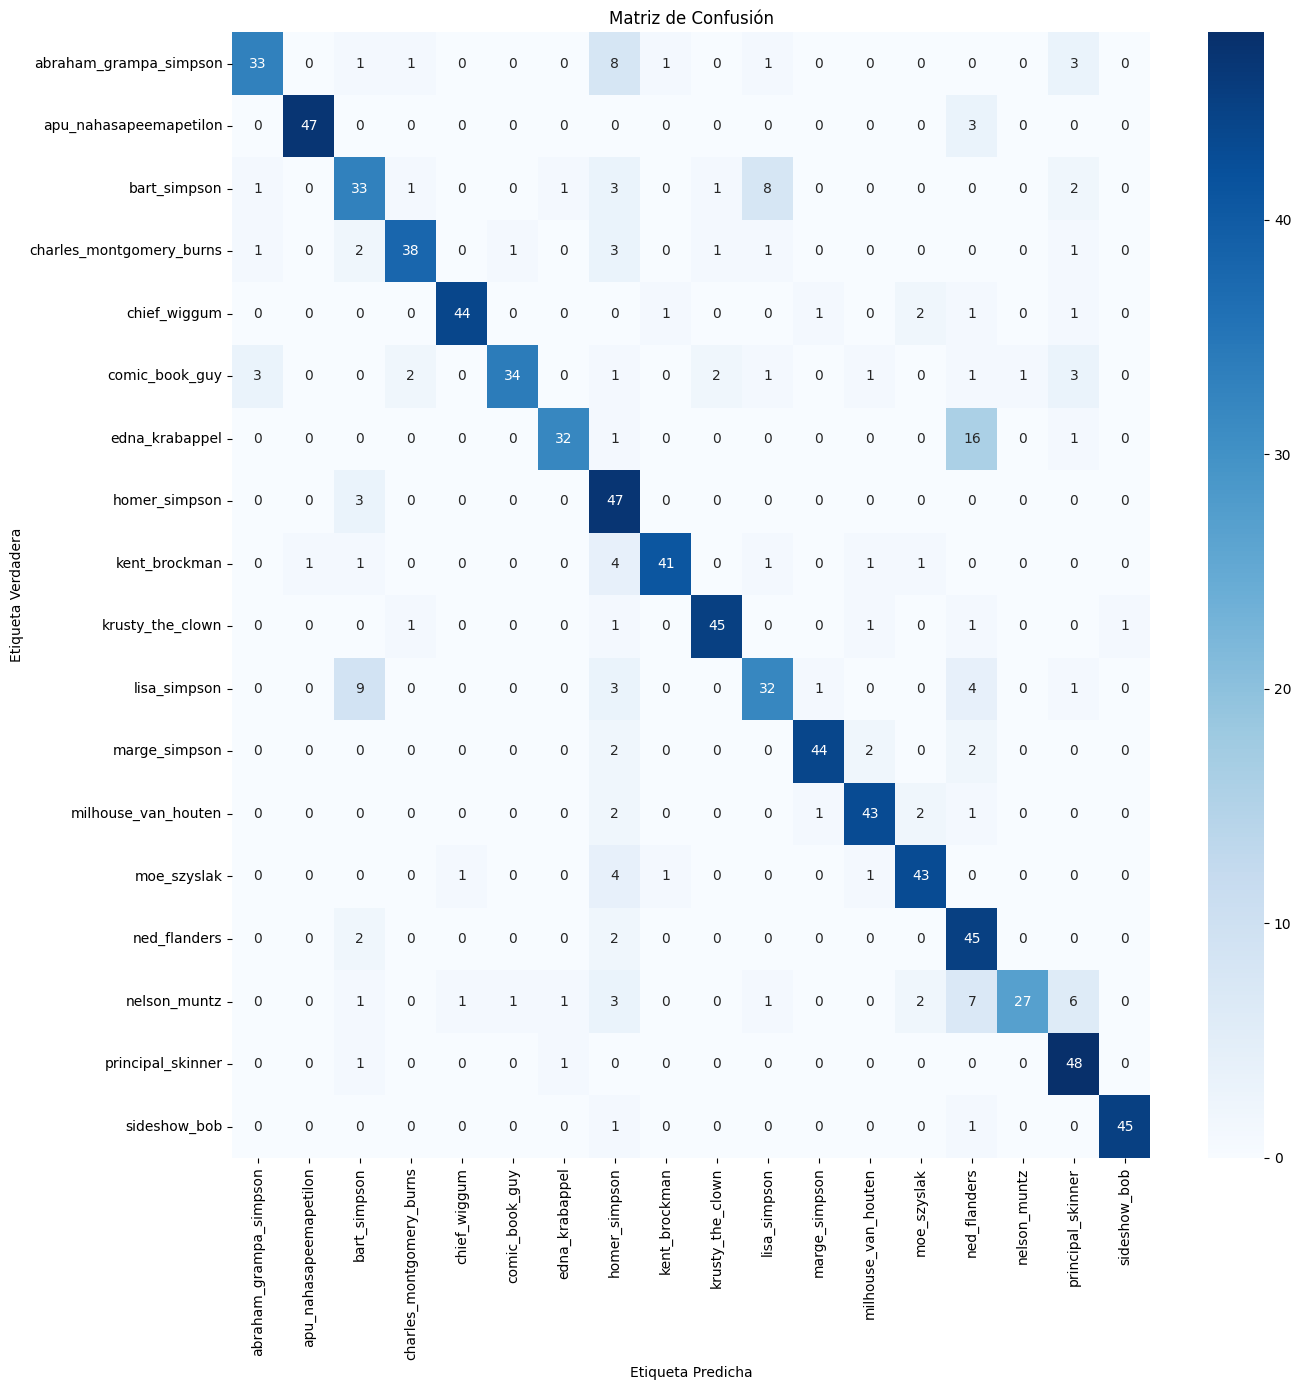

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluación: predicciones sobre el set de test
predictions = model.predict(X_t)
y_pred = np.argmax(predictions, axis=1)

# Reporte de clasificación con nombres de personajes
print(classification_report(y_t, y_pred, target_names=list(MAP_CHARACTERS.values())))

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_t, y_pred)

# Visualizar matriz de confusión con seaborn
plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix,
            annot=True,        # mostrar los números en cada celda
            fmt='d',           # formato entero
            cmap='Blues',      # color
            xticklabels=list(MAP_CHARACTERS.values()),  # etiquetas eje X (predicciones)
            yticklabels=list(MAP_CHARACTERS.values()))  # etiquetas eje Y (verdaderas)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




## Modelo CNN Mejorado: Arquitectura, Justificación y Optimización

### Diseño de la arquitectura CNN

- **Profundidad y número de filtros:**  
  Este modelo tiene una arquitectura más profunda con 3 bloques Conv2D con 32, 64 y 128 filtros respectivamente. Esto permite capturar características más complejas y abstractas de las imágenes, mejorando la capacidad del modelo para diferenciar personajes con rasgos similares.  
  Los filtros de tamaño 3x3 son estándar para capturar detalles locales, y se combinan con MaxPooling para reducir dimensionalidad y evitar sobreajuste.

- **Uso de Batch Normalization y Dropout:**  
  Se incorpora Batch Normalization después de cada capa convolucional para acelerar el entrenamiento y estabilizar la red, ayudando a evitar el problema de covariate shift interno.  
  Se usa Dropout en dos puntos (0.3 después del último MaxPooling y 0.5 antes de la capa final densa) para reducir el sobreajuste, apagando aleatoriamente neuronas y forzando al modelo a generalizar mejor.

- **Regularización L2:**  
  La capa densa usa regularización L2 para penalizar pesos grandes y mejorar la generalización.

### Selección de hiperparámetros

- **Learning rate:**  
  Se utiliza Adam con learning rate 0.0005, un valor menor que el modelo simple para permitir un ajuste más fino en esta arquitectura más compleja.  
- **Batch size:**  
  64, manteniendo un balance entre estabilidad y velocidad de entrenamiento.  
- **Número de epochs:**  
  10, para observar el comportamiento y evitar sobreentrenamiento.

### Optimización y ajuste de hiperparámetros

- El ajuste del learning rate más bajo y la incorporación de BatchNorm y Dropout mejoraron notablemente la estabilidad y precisión del modelo.  
- La regularización L2 ayuda a controlar la magnitud de los pesos, evitando sobreajuste en la capa densa final.  
- Estos ajustes permitieron aumentar la precisión en test y mejorar la capacidad del modelo para generalizar.

### Interpretación de resultados y métricas

El modelo mejorado presenta un rendimiento notablemente superior al modelo simple:  

- **Loss (pérdida) en test:** 0.7871  
- **Accuracy (precisión) en test:** 0.8921 (89.21%)  

Además, al analizar las métricas de precisión, recall y F1-score por clase, se observa un desempeño sólido y equilibrado en la mayoría de los personajes.  

El personaje con mayor dificultad para el modelo es **Abraham Grampa Simpson**, que es confundido principalmente con **Homer Simpson**. Esto se puede atribuir a similitudes visuales y características faciales similares, lo que indica que aún hay margen para mejoras con técnicas más avanzadas o aumento de datos.  

En resumen, la arquitectura más profunda y las técnicas de normalización y regularización implementadas mejoran considerablemente la capacidad de discriminación del modelo para esta tarea de clasificación de personajes.


In [ ]:
from tensorflow.keras.regularizers import l2

model_cnn_deep = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

model_cnn_deep.compile(optimizer=Adam(learning_rate=0.0005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_cnn_deep = model_cnn_deep.fit(X, y_cat, epochs=10, batch_size=64, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.2426 - loss: 3.4384 - val_accuracy: 0.0934 - val_loss: 8.6113
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5013 - loss: 2.1583 - val_accuracy: 0.4680 - val_loss: 2.3251
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6180 - loss: 1.7325 - val_accuracy: 0.6949 - val_loss: 1.4752
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6767 - loss: 1.4935 - val_accuracy: 0.7428 - val_loss: 1.3270
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7415 - loss: 1.2800 - val_accuracy: 0.7468 - val_loss: 1.2901
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7853 - loss: 1.1333 - val_accuracy: 0.7934 - val_loss: 1.1839
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8296 - loss: 0.9912 - val_accuracy: 0.7973 - val_loss: 1.1717
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8457 - loss: 0.9246 - val_acc

In [ ]:
# Evaluar en test el modelo CNN profundo
test_loss, test_accuracy = model_cnn_deep.evaluate(X_t, y_t_cat, verbose=2)
print(f'Loss en test: {test_loss:.4f}')
print(f'Accuracy en test: {test_accuracy:.4f}')


28/28 - 1s - 44ms/step - accuracy: 0.8921 - loss: 0.7871
Loss en test: 0.7871
Accuracy en test: 0.8921


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.50      0.67        48
  apu_nahasapeemapetilon       0.98      0.96      0.97        50
            bart_simpson       0.62      0.92      0.74        50
charles_montgomery_burns       0.83      0.90      0.86        48
            chief_wiggum       0.98      0.88      0.93        50
          comic_book_guy       1.00      0.86      0.92        49
          edna_krabappel       1.00      0.86      0.92        50
           homer_simpson       0.72      0.94      0.82        50
           kent_brockman       0.98      0.84      0.90        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.81      0.86      0.83        50
           marge_simpson       0.98      0.98      0.98        50
     milhouse_van_houten       1.00      0.90      0.95        49
             moe_szyslak       0.83

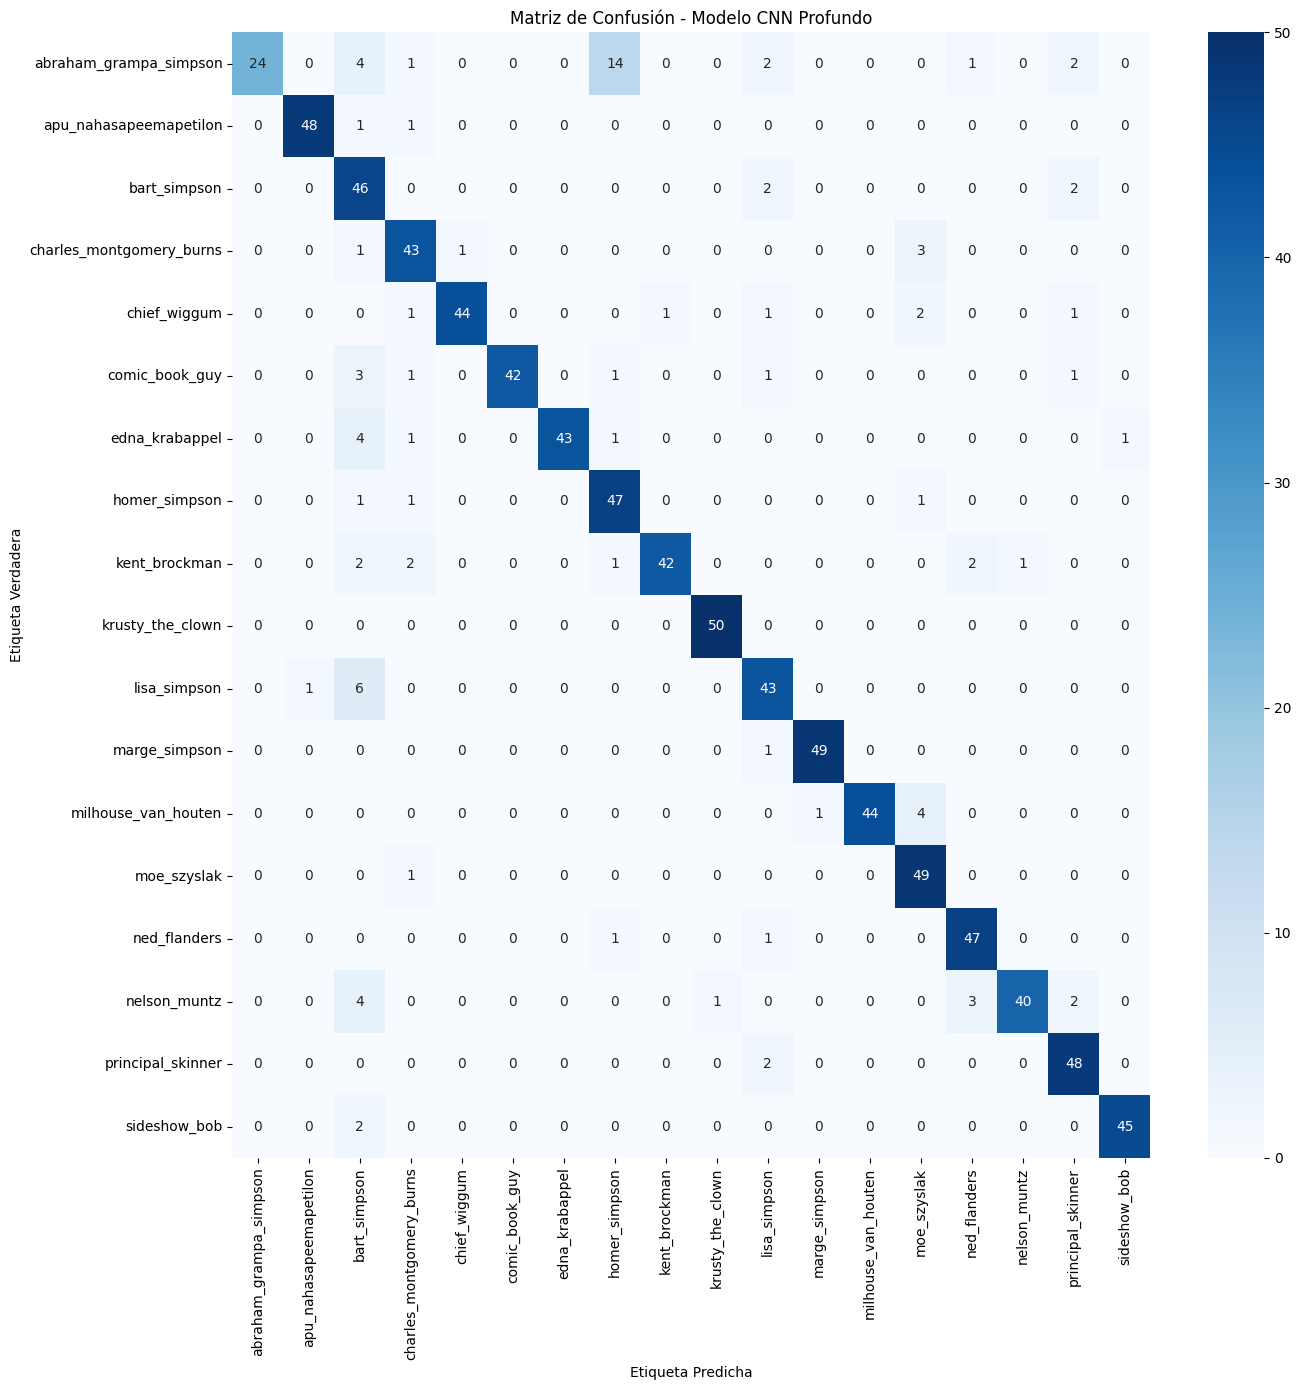

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluación: predicciones sobre el set de test
predictions = model_cnn_deep.predict(X_t)
y_pred = np.argmax(predictions, axis=1)

# Reporte de clasificación con nombres de personajes
print(classification_report(y_t, y_pred, target_names=list(MAP_CHARACTERS.values())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_t, y_pred)

plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix,
            annot=True,        # mostrar los números en cada celda
            fmt='d',           # formato entero
            cmap='Blues',      # color
            xticklabels=list(MAP_CHARACTERS.values()),  # etiquetas eje x (predicciones)
            yticklabels=list(MAP_CHARACTERS.values()))  # etiquetas eje y (verdaderas)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - Modelo CNN Profundo')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


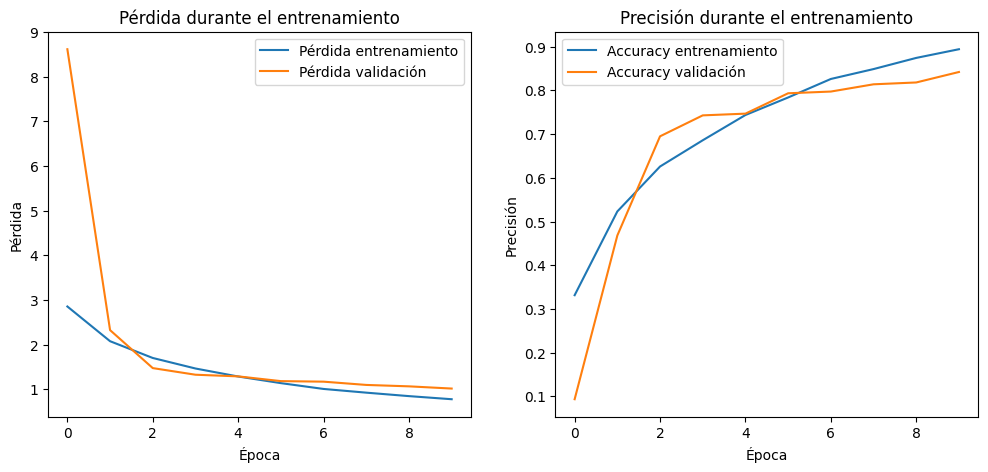

In [ ]:
# Mostrar gráfica de pérdida y accuracy
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history_cnn_deep.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_cnn_deep.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_cnn_deep.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(history_cnn_deep.history['val_accuracy'], label='Accuracy validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()


# Modelo MLP: Arquitectura, Justificación y Resultados

## Diseño de la arquitectura MLP

- **Estructura de capas:**  
  El modelo está compuesto por dos capas densas con 512 y 256 neuronas respectivamente, ambas con activación ReLU para capturar relaciones no lineales entre características.  
  Se utiliza Dropout con tasa 0.3 después de cada capa para ayudar a prevenir sobreajuste y mejorar la generalización.

- **Input Flattened:**  
  Las imágenes se transforman en vectores 1D (`IMG_SIZE * IMG_SIZE * 3`) para ser compatibles con las capas densas.

- **Salida:**  
  La capa final usa softmax para clasificación multiclase, con el número de neuronas igual a la cantidad de personajes a identificar.

## Hiperparámetros

- Optimizador Adam con learning rate por defecto, que adapta el proceso de aprendizaje para acelerar convergencia.  
- Función de pérdida categorical_crossentropy, adecuada para clasificación multiclase.  
- Batch size de 64 y 10 epochs para entrenamiento, balanceando entre tiempo y convergencia.

## Resultados de evaluación en test

- **Loss (pérdida):** 2.5583  
- **Accuracy (precisión):** 0.1978 (19.78%)  

Estas métricas indican que el modelo MLP tiene un desempeño pobre en este problema, con una precisión baja y una pérdida alta, mostrando que no logra aprender patrones discriminativos suficientes a partir de las imágenes aplanadas.

## Métricas detalladas por clase

Se observa que muchas clases tienen precision, recall y f1-score cercanos a cero, indicando que el modelo no las reconoce correctamente. Algunas clases con mejor desempeño:

- `kent_brockman` y `marge_simpson` presentan mejores métricas, con recalls moderados (36% y 44%) y precision aceptable.  
- `homer_simpson` tiene un recall relativamente alto (58%) pero baja precisión, indicando muchas falsas alarmas.

## Interpretación y conclusiones

- La arquitectura MLP simple no es adecuada para este tipo de datos visuales complejos, ya que aplanar las imágenes elimina la estructura espacial crucial para identificar patrones relevantes.  
- Se recomienda usar modelos convolucionales que capturan información espacial local y jerárquica para mejorar significativamente el desempeño.  
- El modelo podría servir como baseline inicial, pero requiere mejoras sustanciales en arquitectura para obtener resultados útiles.


In [ ]:
# Aplanar las imágenes para el MLP
X_flat = X.reshape(X.shape[0], -1)
X_t_flat = X_t.reshape(X_t.shape[0], -1)


In [ ]:
model_mlp = Sequential([
    Dense(512, activation='relu', input_shape=(IMG_SIZE * IMG_SIZE * 3,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

model_mlp.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_mlp = model_mlp.fit(X_flat, y_cat, epochs=10, batch_size=64, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1021 - loss: 3.6749 - val_accuracy: 0.2066 - val_loss: 2.5449
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1678 - loss: 2.6184 - val_accuracy: 0.2316 - val_loss: 2.4717
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1902 - loss: 2.5537 - val_accuracy: 0.2669 - val_loss: 2.4214
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1886 - loss: 2.5327 - val_accuracy: 0.2535 - val_loss: 2.4253
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2023 - loss: 2.4978 - val_accuracy: 0.2361 - val_loss: 2.4746
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2036 - loss: 2.4921 - val_accuracy: 0.2648 - val_loss: 2.3645
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2098 - loss: 2.4930 - val_accuracy: 0.2835 - val_loss: 2.3730
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2179 - loss: 2.4586 - val_accuracy: 0

In [ ]:
# Evaluar en test el modelo MLP
test_loss, test_accuracy = model_mlp.evaluate(X_t_flat, y_t_cat, verbose=2)
print(f'Loss en test: {test_loss:.4f}')
print(f'Accuracy en test: {test_accuracy:.4f}')


28/28 - 1s - 38ms/step - accuracy: 0.1978 - loss: 2.5583
Loss en test: 2.5583
Accuracy en test: 0.1978


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.00      0.00      0.00        48
  apu_nahasapeemapetilon       0.00      0.00      0.00        50
            bart_simpson       0.18      0.36      0.24        50
charles_montgomery_burns       0.00      0.00      0.00        48
            chief_wiggum       0.25      0.08      0.12        50
          comic_book_guy       0.00      0.00      0.00        49
          edna_krabappel       0.00      0.00      0.00        50
           homer_simpson       0.12      0.58      0.20        50
           kent_brockman       0.72      0.36      0.48        50
        krusty_the_clown       0.42      0.56      0.48        50
            lisa_simpson       0.00      0.00      0.00        50
           marge_simpson       0.73      0.44      0.55        50
     milhouse_van_houten       0.18      0.31      0.23        49
             moe_szyslak       0.16

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


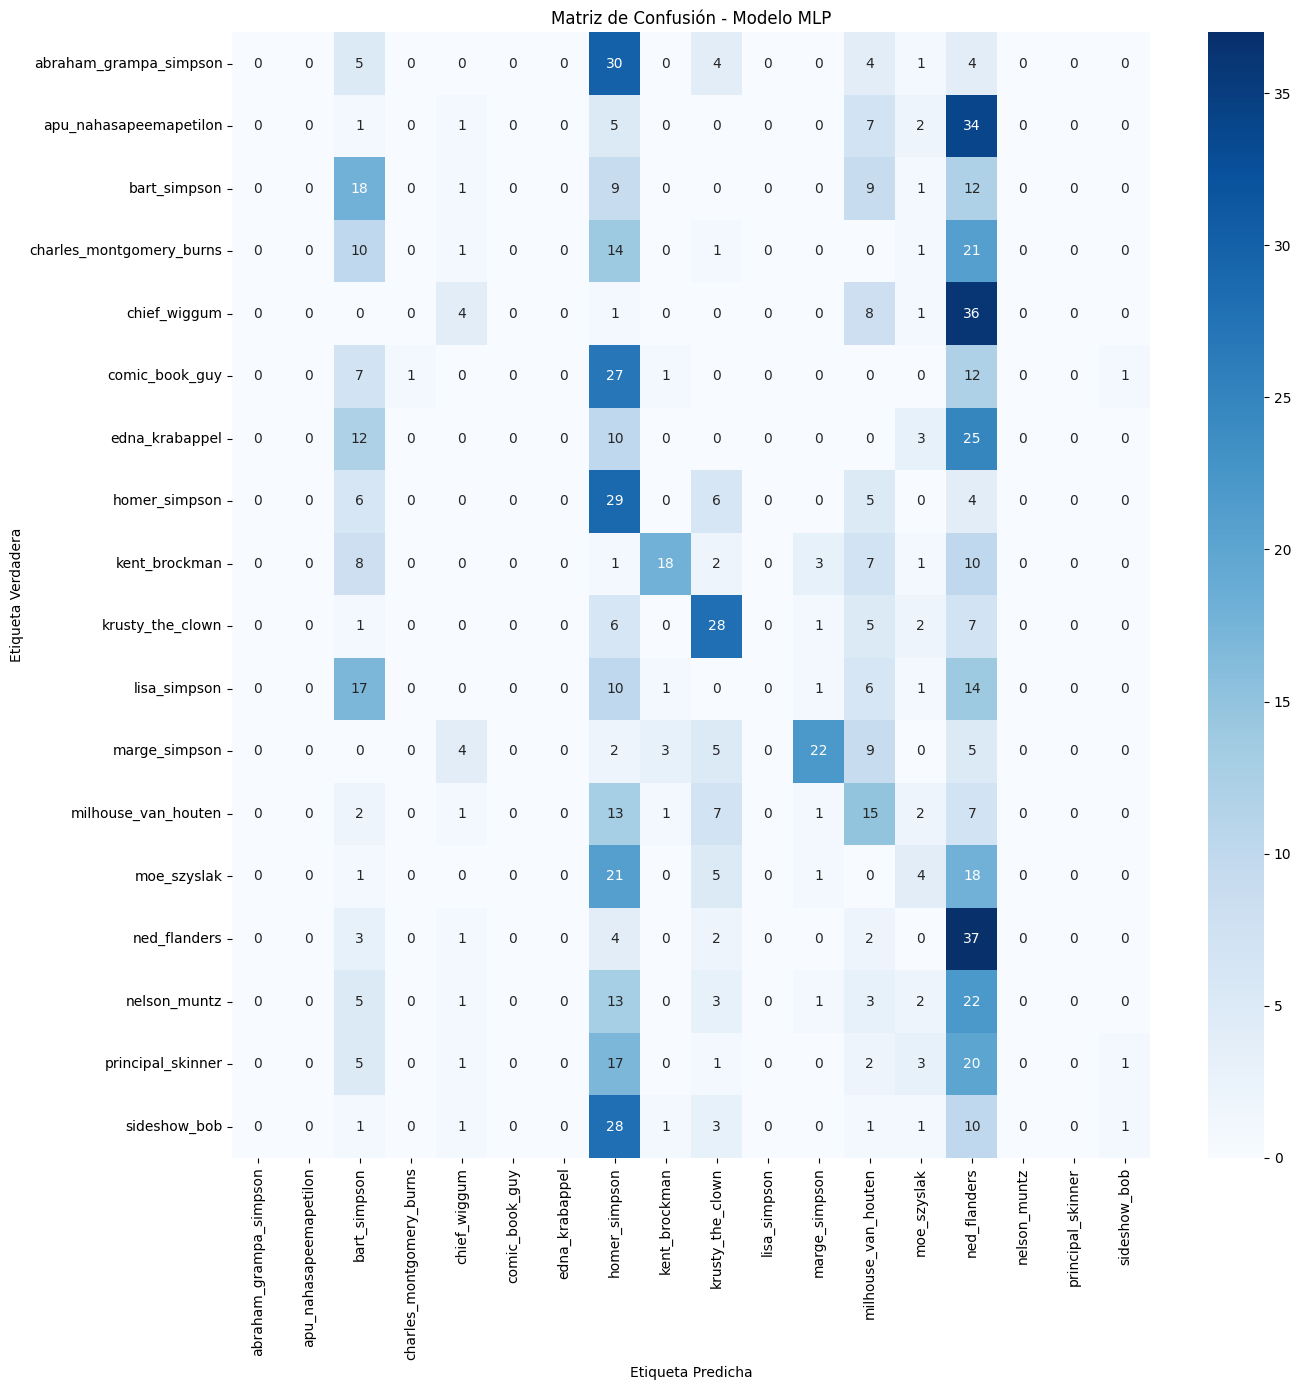

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicciones sobre el set de test aplanado
predictions = model_mlp.predict(X_t_flat)
y_pred = np.argmax(predictions, axis=1)

# Reporte de clasificación con nombres de personajes
print(classification_report(y_t, y_pred, target_names=list(MAP_CHARACTERS.values())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_t, y_pred)

plt.figure(figsize=(14, 14))
sns.heatmap(conf_matrix,
            annot=True,        # mostrar los números en cada celda
            fmt='d',           # formato entero
            cmap='Blues',      # color
            xticklabels=list(MAP_CHARACTERS.values()),  # etiquetas eje x (predicciones)
            yticklabels=list(MAP_CHARACTERS.values()))  # etiquetas eje y (verdaderas)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - Modelo MLP')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Comparación de Modelos y Selección Final

Durante el desarrollo del proyecto se entrenaron y evaluaron tres enfoques distintos para la clasificación de imágenes de personajes de Los Simpsons:

1. **MLP (Perceptrón Multicapa)** utilizando imágenes aplanadas como entrada.
2. **CNN simple**, con una arquitectura básica de convolución.
3. **CNN profundo mejorado**, con múltiples capas convolucionales, normalización y regularización.

## Desempeño en el conjunto de prueba

| Modelo               | Accuracy | Loss   | Comentarios clave |
|----------------------|----------|--------|--------------------|
| **MLP**              | 0.1978   | 2.5583 | Muy bajo rendimiento; no aprende patrones útiles. |
| **CNN simple**       | 0.8101   | 0.6985 | Buen desempeño general; algunas confusiones entre clases similares. |
| **CNN profundo**     | **0.8921** | **0.7871** | Mejor desempeño global; alta precisión y menor confusión. |

## Análisis por modelo

### 1. Modelo MLP

- **Loss**: 2.5583  
- **Accuracy**: 19.78%

El modelo MLP mostró un desempeño muy bajo. Al trabajar con imágenes aplanadas, pierde completamente la estructura espacial, lo que limita gravemente su capacidad de extraer características relevantes. Las métricas por clase reflejan que no logra discriminar entre los personajes de forma efectiva, y su aprendizaje es casi aleatorio.

---

### 2. Modelo CNN simple

- **Loss**: 0.6985  
- **Accuracy**: 81.01%

Este modelo logró extraer características básicas y obtener una precisión aceptable. Sin embargo, presenta limitaciones al diferenciar personajes con rasgos visuales similares. Algunas de las confusiones más frecuentes se dan entre:

- **Edna Krabappel** y **Ned Flanders**  
- **Lisa Simpson** y **Bart Simpson**  
- **Abraham Grampa Simpson** y **Homer Simpson**

Estas confusiones son esperables considerando la arquitectura poco profunda y la ausencia de técnicas más avanzadas de regularización o normalización. Aun así, logra un buen rendimiento en personajes bien diferenciados.

---

### 3. Modelo CNN profundo mejorado

- **Loss**: 0.7871  
- **Accuracy**: 89.21%

Este modelo presentó el mejor desempeño. La arquitectura más profunda, junto con técnicas como **Batch Normalization** y **Dropout**, permitió mejorar significativamente la capacidad de generalización del modelo. Las métricas por clase son sólidas, mostrando precisión y recall elevados de forma consistente.

La confusión más notoria ocurrió entre **Abraham Grampa Simpson** y **Homer Simpson**, probablemente debido a sus similitudes faciales, pero en general el modelo manejó muy bien la mayoría de las clases.

---

## Conclusión

El modelo **CNN profundo** fue seleccionado como el modelo final debido a su superior desempeño global y estabilidad en la clasificación de múltiples clases. Superó al modelo CNN simple tanto en precisión como en robustez, y mostró una mejora sustancial respecto al MLP, que no fue adecuado para este tipo de datos.

Esta decisión se fundamenta en métricas objetivas (accuracy, loss y métricas por clase), así como en un análisis cualitativo de los errores comunes observados en las matrices de confusión. La arquitectura profunda demostró ser la más eficaz para capturar las complejidades visuales necesarias en esta tarea de clasificación.
